In [3]:
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import json
import re
import sys

# Make a shortcut to 2357 Screw Sorter folder on your personal drive
DATA_DIR = "/content/drive/MyDrive/2357 Screw Sorter/Data Clean/"

In [ ]:
#                 C L A S S I F I C A T I O N    P L A N
#
# predict on 5 output classes: head, drive, thread, length, width
#
# additional binary measurement system classifier
#
# width:  regression classifier [input binarized cropped images + coordinates of cropping]
# length: regression classifier [input binarized cropped images + coordinates of cropping]
# pitch:  regression classifier [input binarized cropped dft + coordinates of cropping]
# head:   discrete classifier   [input binarized cropped image]
# drive:  discrete classifier   [input side-on cropped image]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Import

In [ ]:
INCH_TO_MM = 25.4

num2inchwidth = [
    0.060, # No.0
    0.073, # No.1
    0.086, # No.2
    0.099, # No.3
    0.112, # No.4
    0.125, # No.5
]

def sfrac2float(s):
  """
  in:  str fraction "{num}/{denom}"
  out: float
  """
  nums = s.split("/")
  return int(nums[0]) / int(nums[1])

def processMetric(label):
  """
  in:  metric label dict
  out: unified metric label dict
  """
  w = float(label["thread_size"].split("M")[-1])
  l = float(label["length"].split("mm")[0])
  p = float(label["thread_pitch"].split("mm")[0])
  return {"width": w, "length": l, "pitch": p, "metric": True}

def processImperial(label):
  """
  in:  imperial label dict
  out: unified metric label dict
  """
  thread_size = label["thread_size"].split("-")
  w = num2inchwidth[int(thread_size[0])]*INCH_TO_MM
  l = sfrac2float(label["length"].split('"')[0])*INCH_TO_MM
  p = 1.0/int(thread_size[1])*INCH_TO_MM
  return {"width": w, "length": l, "pitch": p, "metric": False}


In [ ]:
data_frames = []
THRESH = 150 #70

home = os.getcwd()
os.chdir(DATA_DIR)
data_directories = [f for f in os.listdir(DATA_DIR) if os.path.isdir(f)]
count = 0
for data_directory in data_directories:
  os.chdir(data_directory)
  metadata_file = [f for f in os.listdir() if not os.path.isdir(f)][0]
  with open(metadata_file) as mf:

    metadata = json.load(mf)
    label = {}

    if re.match("M", metadata["thread_size"]):
      label = processMetric(metadata)
    else:
      label = processImperial(metadata)

    image_directories = [f for f in os.listdir() if os.path.isdir(f)]
    for image_directory in image_directories:
      os.chdir(image_directory)
      image_files = os.listdir()
      for image_file in image_files:
        if re.match(".*_top", image_file):
          count += 1
          img = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
          grey = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
          ret,thresh = cv2.threshold(grey,THRESH,255,cv2.THRESH_BINARY)
          data_frames.append(pd.DataFrame({**label,**{"top-down":[thresh]}}, index=[data_directory]))
  os.chdir(DATA_DIR)
os.chdir(home)
label_set_persistent = pd.concat(data_frames)
label_set_persistent.head()

,width,length,pitch,metric,top-down
92210A081,2.1844,12.7000,0.453571,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92949A899,2.5146,7.9375,0.529167,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92000A013,2.0000,6.0000,0.400000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92125A058,2.0000,12.0000,0.400000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92125A126,3.0000,6.0000,0.500000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Visualize Labels



<Axes: xlabel='length'>

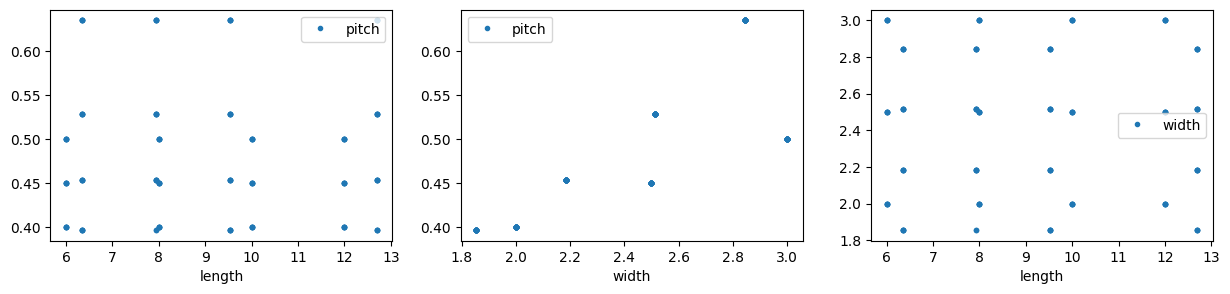

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)

label_set_persistent.plot(x="length", y="pitch", style=".", ax=axes[0])
label_set_persistent.plot(x="width", y="pitch", style=".", ax=axes[1])
label_set_persistent.plot(x="length", y="width", style=".", ax=axes[2], figsize=(15,3))

In [ ]:
print("Unique pitches: {l}".format(l=list(label_set_persistent["pitch"].unique())))
print("Unique widths:  {l}".format(l=list(label_set_persistent["width"].unique())))
print("Unique lengths: {l}".format(l=list(label_set_persistent["length"].unique())))

Unique pitches: [0.4535714285714285, 0.5291666666666666, 0.4, 0.5, 0.45, 0.635, 0.396875]
Unique widths:  [2.1843999999999997, 2.5146, 2.0, 3.0, 2.5, 2.8447999999999998, 1.8541999999999998]
Unique lengths: [12.7, 7.9375, 6.0, 12.0, 8.0, 9.524999999999999, 6.35, 10.0]


# Image Data Processing

In [4]:
def _get_center(contours, x, y, vx, vy):
  err1 = sys.float_info.max
  err2 = sys.float_info.max
  p1 = (0,0)
  p2 = (0,0)
  m = -vy[0]/vx[0]
  p0_x = x[0]
  p0_y = y[0]

  for c in contours:
    p_x = c[0][0]
    p_y = c[0][1]
    if abs(-(p0_y-p_y)/(p0_x-p_x) - m) < err1 and p_x < p0_x:
      err1 = abs(-(p0_y-p_y)/(p0_x-p_x) - m)
      p1 = (p_x,p_y)
    if abs(-(p_y-p0_y)/(p_x-p0_x) - m) < err2 and p_x > p0_x:
      err2 = abs(-(p_y-p0_y)/(p_x-p0_x) - m)
      p2 = (p_x,p_y)

  return (int((p2[0] + p1[0])/2), int((p2[1] + p1[1])/2))

def _adjust_vec(vx, vy, x_center, y_center, x_centroid, y_centroid):
  vec = None
  if x_centroid >= x_center and y_centroid < y_center:
    vec = (abs(vx), abs(vy))
  elif x_centroid < x_center and y_centroid <= y_center:
    vec = (-abs(vx), abs(vy))
  elif x_centroid <= x_center and y_centroid > y_center:
    vec = (-abs(vx), -abs(vy))
  else:
    vec = (abs(vx), -abs(vy))
  return vec

def _normalize_direction(x_center, y_center, x_centroid, y_centroid, theta_curr):
  theta_correction = 0.0
  if x_centroid >= x_center and y_centroid < y_center:
    theta_correction = -theta_curr
  elif x_centroid < x_center and y_centroid <= y_center:
    theta_correction = -theta_curr
  elif x_centroid <= x_center and y_centroid > y_center:
    theta_correction = theta_curr
  else:
    theta_correction = theta_curr
  return theta_correction

def _straighten(image, center, theta):
   """
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   """
   shape = (image.shape[1], image.shape[0])
   matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)
   return cv2.warpAffine(src=image, M=matrix, dsize=shape)

def _crop(img):
  contours,_ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
  x,y,w,h = cv2.boundingRect(contours_sorted[1])
  return [img[y:y+h,x:x+w]]

class AlignCropTransformer(BaseEstimator, TransformerMixin):
  """
  Column transformer for straightening and cropping screw images
  """
  row_max = 0
  col_max = 0

  def get_colMax(self):
    return self.col_max

  def get_rowMax(self):
    return self.row_max

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    """
    in:       Binarized full-size screw image
    out:      Binarized images cropped and straightened about screw
    creates:  Column for bounding-box center point, bounding-box width,
              bounding-box height
    """
    def _do_transform(img):
      contours,_ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
      contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

      [vx,vy,x,y] = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)

      M = cv2.moments(contours_sorted[1])
      x_centroid = int(M['m10']/M['m00'])
      y_centroid = int(M['m01']/M['m00'])
      x_center, y_center = _get_center(contours_sorted[1], x, y, vx, vy)
      vec = _adjust_vec(vx[0], vy[0], x_center, y_center, x_centroid, y_centroid)
      theta = np.arccos(np.dot([vec[0],vec[1]], [1,0]))*180/np.pi

      theta_adjusted = _normalize_direction(x_center, y_center, x_centroid, y_centroid, theta)

      img = _straighten(img, (x_center, y_center), theta_adjusted)
      img = _crop(img)
      if img.shape[0] > self.row_max:
        self.row_max = img.shape[0]
      if img.shape[1] > self.col_max:
        self.col_max = img.shape[1]
      return img

    return pd.DataFrame([_do_transform(img[0]) for img in X.values], dtype=object)

class ShapeTransformer(BaseEstimator, TransformerMixin):
  pass

In [ ]:
img_feats = ["top-down"]
ohe_feats = ["metric"]
pth_feats = ["length", "width", "pitch"]

ct = make_column_transformer(
       (AlignCropTransformer(),              img_feats),
       (OneHotEncoder(drop="if_binary"), ohe_feats),
       ('passthrough',                   pth_feats)
     )

column_names = (
    img_feats
    + ohe_feats
    + pth_feats
)

transformed = pd.DataFrame(ct.fit_transform(label_set_persistent), columns=column_names)
transformed.head()

(-0.09107583, -0.99584395) 0.09107583 -0.99584395
95.22550182273834
2725 1870 2724 1894
(-0.31438586, -0.9492953) 0.31438586 -0.9492953
108.32374278224658
2680 1543 2673 1557
(-0.05360972, -0.998562) 0.05360972 -0.998562
93.07308398374768
2759 1715 2754 1732
(-0.76482517, -0.6442379) 0.76482517 -0.6442379
139.8914404516546
2740 1774 2727 1782
(-0.27837786, -0.96047163) 0.27837786 -0.96047163
106.16341420445167
2891 1721 2886 1738
(-0.8843675, -0.46679127) 0.8843675 -0.46679127
152.17378899958567
2828 1914 2808 1923
(-0.9812905, -0.1925329) 0.9812905 -0.1925329
168.8993617252749
3170 1973 3150 1974
(-0.98229384, 0.18734664) 0.98229384 0.18734664
169.20201628560167
2722 1781 2702 1777
(0.99885684, -0.047801614) 0.99885684 0.047801614
2.7398831579691936
2744 1720 2769 1730
(-0.06466566, 0.997907) 0.06466566 0.997907
93.70765649941711
2734 1998 2733 1981
(-0.9837794, -0.17938285) 0.9837794 -0.17938285
169.66619465873984
2894 1865 2880 1866
(0.060772814, 0.9981516) 0.060772814 0.9981516
86.

,top-down,metric,length,width,pitch
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0.0,12.7,2.1844,0.453571
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0.0,7.9375,2.5146,0.529167
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1.0,6.0,2.0,0.4
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1.0,12.0,2.0,0.4
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1.0,6.0,3.0,0.5


In [ ]:
d = transformed.query("length == 6.0 & width == 3.0")
d2 = label_set_persistent.query("length == 6.0 & width == 3.0")
# print(d2.head())


# i = d.iloc[3,0]
# plt.imshow(i, cmap="gray")

fig = plt.figure(figsize=(15, 15))
columns = 10
rows = 16
for i, img in enumerate(transformed.iloc[:,0]):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img, cmap="gray")
plt.show()

# display(transformed.iloc[67])

# i_color = cv2.cvtColor(i, cv2.COLOR_GRAY2RGB)
# contours,_ = cv2.findContours(i, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
# rows,cols = i_color.shape[:2]
# [vx,vy,x,y] = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)
# vx, vy, x, y = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)

# M = cv2.moments(contours_sorted[1])
# x_centroid = int(M['m10']/M['m00'])
# y_centroid = int(M['m01']/M['m00'])

# print(vx, vy, x, y)
# print(type(x[0]))
# i_color = cv2.circle(i_color, (int(x[0]),int(y[0])), 1, color=(255,0,0), thickness=-1)
# i_color = cv2.circle(i_color, (int(x_centroid),y_centroid), 1, color=(0,255,0), thickness=-1)
# lefty = int((-x*vy/vx) + y)
# righty = int(((cols-x)*vy/vx)+y)
# # cv2.line(i_color,(cols-1,righty),(0,lefty),(0,0,255),2)
# # print(vx,vy)
# # plt.imshow(i_color)
# # print(_adjust_vec(vx[0], vy[0], x, y, x_centroid, y_centroid))
# # t = i_color[1250:2250,2500:3000]
# # SCALE = 20
# # new_shape = (t.shape[1]*SCALE, t.shape[0]*SCALE)
# # t = cv2.resize(t, new_shape, interpolation= cv2.INTER_LINEAR)

# err1 = sys.float_info.max
# err2 = sys.float_info.max
# p1 = (0,0)
# p2 = (0,0)
# m = -vy[0]/vx[0]
# p0_x = x[0]
# p0_y = y[0]

# for c in contours_sorted[1]:
#   p_x = c[0][0]
#   p_y = c[0][1]
#   if abs(-(p0_y-p_y)/(p0_x-p_x) - m) < err1 and p_x < p0_x:
#     err1 = abs(-(p0_y-p_y)/(p0_x-p_x) - m)
#     p1 = (p_x,p_y)
#   if abs(-(p_y-p0_y)/(p_x-p0_x) - m) < err2 and p_x > p0_x:
#     err2 = abs(-(p_y-p0_y)/(p_x-p0_x) - m)
#     p2 = (p_x,p_y)
#     pass
#   else:
#     pass

#   # i_color = cv2.circle(i_color, (c[0][0], c[0][1]), 2, color=(0,255,0), thickness=-1)
# print(p1,p2)
# print(err1, err2)

# c = (int((p2[0] + p1[0])/2), int((p2[1] + p1[1])/2))

# i_color = cv2.circle(i_color, p1, 2, color=(255,0,0), thickness=-1)
# i_color = cv2.circle(i_color, p2, 2, color=(255,0,0), thickness=-1)
# i_color = cv2.circle(i_color, c, 2, color=(255,0,0), thickness=-1)

# plt.imshow(i_color[2250:2500,2500:3000])
# plt.imshow(i_color)

#uncomment to here for debug

# M = cv2.moments(contours_sorted[0])
# theta = rect[-1]
# w = int(math.ceil(rect[1][0]))
# h = int(math.ceil(rect[1][1]))
# x_center = int(rect[0][0])
# y_center = int(rect[0][1])
# x_centroid = int(M['m10']/M['m00'])
# y_centroid = int(M['m01']/M['m00'])

# print((x_center, y_center))
# print((x_centroid, y_centroid))
# cv2.circle(d2.iloc[3,4], (x_center,y_center), 10, color=(255,0,0), thickness=-1)
# cv2.circle(d2.iloc[3,4], (x_centroid,y_centroid), 10, color=(0,255,0), thickness=-1)
# plt.imshow(d.iloc[3,0], cmap="gray")
# # plt.imshow(d2.iloc[3,4], cmap="gray")

# img = d.iloc[3,0]
# img = cv2.copyMakeBorder(
#     img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
# contours,_ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
# rows,cols = img.shape[:2]
# [vx,vy,x,y] = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)
# vx, vy, x, y = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)
# print(vx, vy, x, y)
# lefty = int((-x*vy/vx) + y)
# righty = int(((cols-x)*vy/vx)+y)
# color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB);
# cv2.line(color_img,(cols-1,righty),(0,lefty),(0,0,255),2)
# # print(contours_sorted[0].shape)
# # print(type(contours_sorted[0]))

# p = (int(x[0]),int(y[0]))
# m = (x_centroid, y_centroid)
# print(vx,vy)

# M = cv2.moments(contours_sorted[1])

# # calculate x,y coordinate of center
# cX = int(M["m10"] / M["m00"])
# cY = int(M["m01"] / M["m00"])
# cv2.circle(color_img, p, 5, color=(0,255,0), thickness=-1)
# cv2.circle(color_img, (cX,cY), 5, color=(255,0,0), thickness=-1)

# c = np.dot([vx[0],-vy[0]], [1,0])
# theta = 180-np.arccos(c)*180/np.pi
# print(theta)

# shape = (color_img.shape[1]+200, color_img.shape[0])
# matrix = cv2.getRotationMatrix2D(center=p, angle=theta, scale=1)
# image = cv2.warpAffine(src=color_img, M=matrix, dsize=shape)

# # for c in contours_sorted[2]:

# # #   # print(abs(((c[0][1]-y)/c[0][0]-x)))
# # #   print(vx)
# # #   print(vy)
# #   if (c[0][1]-y)/(c[0][0]-x) - vy/vx < 0.0000001:
# #     # print(c[0][0], c[0][1])
#     # cv2.circle(color_img, (c[0][0], c[0][1]), 2, color=(0,255,0), thickness=-1)
# #     break

# plt.imshow(image)
# # plt.imshow(color_img)

top-down    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
metric                                                    0.0
length                                                   6.35
width                                                  2.5146
pitch                                                0.529167
Name: 67, dtype: object

<!--  -->

            width  length     pitch  metric  \
92210A081  2.1844    12.7  0.453571   False   

                                                    top-down  
92210A081  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
<class 'numpy.ndarray'>


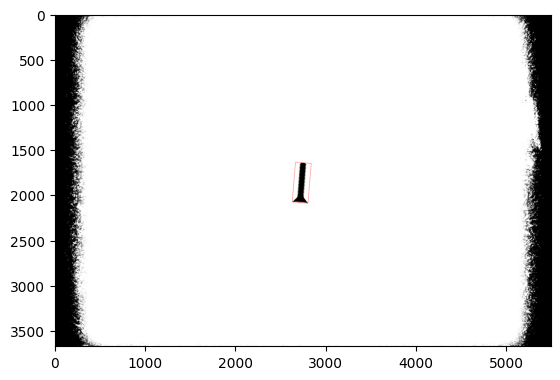

In [ ]:
label_set_persistent.iloc[:1]["top-down"]
print(label_set_persistent.iloc[:1])
label_set_persistent["top-down"].values[0].shape
img = label_set_persistent["top-down"].values[0]
plt.imshow(img, cmap="gray")
print(type(img))
contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
rect = cv2.minAreaRect(contours_sorted[1])
box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
box = np.int0(box)
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(color_img,[box],0,(255,0,0),2)
plt.imshow(color_img)

In [ ]:
def subimage(image, center, theta, width, height):
   """
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   """
   shape = (image.shape[1], image.shape[0])
   matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)
   image = cv2.warpAffine(src=image, M=matrix, dsize=shape)

   w = int(math.ceil(width))
   h = int(math.ceil(height))
   c0 = int(math.ceil(center[0]))
   c1 = int(math.ceil(center[1]))
   x = int(c0 - w/2)
   y = int(c1 - h/2)

   image = image[y:y+h, x:x+w]
   return image

img0 = subimage(img, rect[0], rect[-1], rect[1][0], rect[1][1])
plt.imshow(img0, cmap="gray")

NameError: ignored

In [ ]:
# ct = make_column_transformer(
#     (StandardScaler(), numeric_feats),  # scaling on numeric features
#     (OneHotEncoder(), categorical_feats),  # OHE on categorical features
#     ("passthrough", passthrough_feats),  # no transformations on the binary features
#     ("drop", drop_feats),  # drop the drop features
# )

dtype: uint8, shape: (3672, 5496, 4), min: 2, max: 255


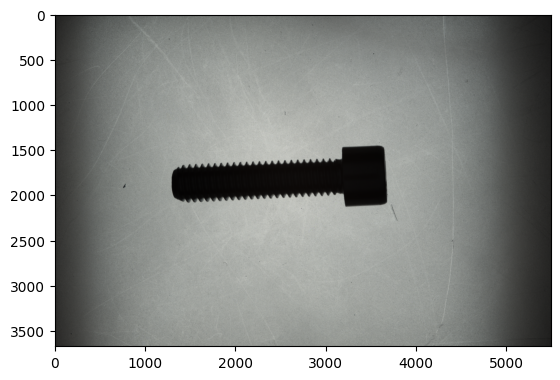

In [ ]:
# os.chdir("/content/drive/MyDrive/2306 Screw Sorter/Experimentation/april-8-imaging-station/fstop/")
os.chdir("/content/drive/MyDrive/2306 Screw Sorter/Experimentation/april-8-imaging-station/backlight-intensity/55/")

# img = cv2.imread('fstop-16-best-focus-50%.tiff', cv2.IMREAD_UNCHANGED)
img = cv2.imread('big-bolt.tiff', cv2.IMREAD_UNCHANGED)
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')
plt.imshow(img)
os.chdir("/content")

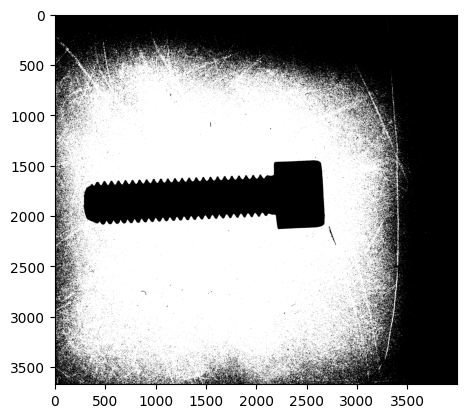

In [ ]:
img0 = img[:,1000:5000]
grey0 = cv2.cvtColor(img0, cv2.COLOR_RGBA2GRAY)
ret,thresh0 = cv2.threshold(grey0,150,255,cv2.THRESH_BINARY)

plt.imshow(thresh0,cmap="gray")

In [ ]:
contours, hierarchy = cv2.findContours(thresh0, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

for c in contours_sorted[0:10]:
    rect = cv2.boundingRect(c)
    if rect[2] < 100 or rect[3] < 100: continue
    print(cv2.contourArea(c))
    x,y,w,h = rect
    color_thresh0 = cv2.cvtColor(thresh0, cv2.COLOR_GRAY2RGB);
    cv2.rectangle(color_thresh0,(x,y),(x+w,y+h),(255,0,0),2)

9566591.5
1047874.0
5989.0


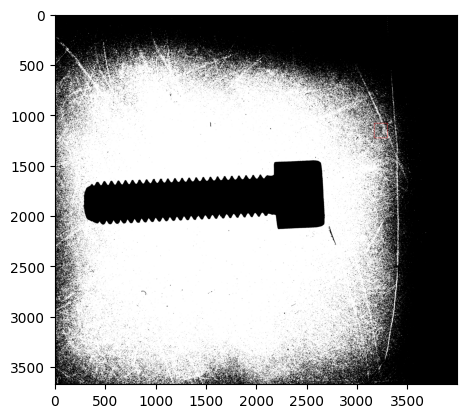

In [ ]:
plt.imshow(color_thresh0)

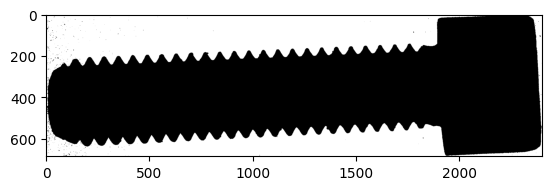

In [ ]:
def resize_shape(scale):
  pass

BUFFER = 0

rect = cv2.boundingRect(contours_sorted[1])
x,y,w,h = rect
screw0 = thresh0[y-BUFFER:y+h+BUFFER,x-BUFFER:x+w+BUFFER]
# SCALE = 4
# new_shape = (screw0.shape[0]*SCALE, screw0.shape[1]*SCALE)
# cv2.resize(screw0, new_shape, interpolation= cv2.INTER_LINEAR)
plt.imshow(screw0, cmap="gray")

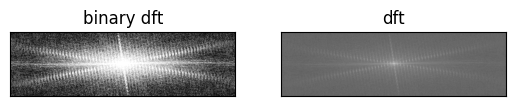

In [ ]:
# find the discrete fourier transform of the image
dft = cv2.dft(np.float32(screw0),flags = cv2.DFT_COMPLEX_OUTPUT)

# shift zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(
      dft_shift[:,:,0],
      dft_shift[:,:,1])
   )

ret,thresh1 = cv2.threshold(magnitude_spectrum,190,255,cv2.THRESH_BINARY)

plt.subplot(121),plt.imshow(thresh1, cmap = 'gray')
plt.title('binary dft'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('dft'), plt.xticks([]), plt.yticks([])
plt.show()

1596 1825
1475 1833


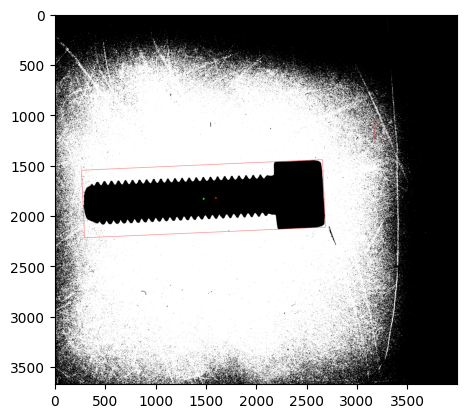

In [ ]:
rect = cv2.minAreaRect(contours_sorted[1])
M = cv2.moments(contours_sorted[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

c0 = int(math.ceil(rect[0][0]))
c1 = int(math.ceil(rect[0][1]))

print(cx, cy)
print(c0, c1)
cv2.circle(color_thresh0, (cx,cy), 10, color=(255,0,0), thickness=-1)
cv2.circle(color_thresh0, (c0,c1), 10, color=(0,255,0), thickness=-1)

box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
box = np.int0(box)
cv2.drawContours(color_thresh0,[box],0,(255,0,0),2)
plt.imshow(color_thresh0)
#crop and rotate by min area rect

def normalize_direction(x_center, y_center, x_centroid, y_centroid, theta_curr):
  theta_correction = 0.0
  switch_crop = False
  if x_centroid > x_center and y_centroid < y_center:
    theta_correction = -(90.0 - theta_curr)
    switch_crop = True
  elif x_centroid < x_center and y_centroid < y_center:
    theta_correction = (180 + theta_curr)
  elif x_centroid < x_center and y_centroid > y_center:
    theta_correction = (180-(90-theta_curr))
    switch_crop = True
  else:
    theta_correction = (theta_curr)
  return (theta_correction, switch_crop)

(1474.0643310546875, 1832.890380859375)
87.47917175292969
2393.455078125
671.2743530273438


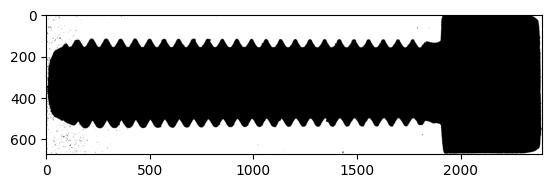

In [ ]:
def subimage(image, center, theta, width, height):

   '''
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   '''
   # Uncomment for theta in radians
   #theta *= 180/np.pi

   w = int(math.ceil(width))
   h = int(math.ceil(height))
   c0 = int(math.ceil(center[0]))
   c1 = int(math.ceil(center[1]))
   x = int(c0 - w/2)
   y = int(c1 - h/2)

   n = normalize_direction(c0, c1, cx, cy, theta)

   shape = (image.shape[1], image.shape[0]) # cv2.warpAffine expects shape in (length, height)
   matrix = cv2.getRotationMatrix2D(center=center, angle=n[0], scale=1)
   image = cv2.warpAffine(src=image, M=matrix, dsize=shape)

   if n[-1]:
    dy = int(w/2)
    dx = int(h/2)
    image = image[c1-dy:c1+dy, c0-dx:c0+dx]
   else:
    image = image[y:y+h, x:x+w]
   return image

test0 = thresh0
test1 = subimage(test0, rect[0], rect[-1], rect[1][0], rect[1][1])
print(rect[0])
print(rect[-1])
print(rect[1][1])
print(rect[1][0])
plt.imshow(test1, cmap="gray")

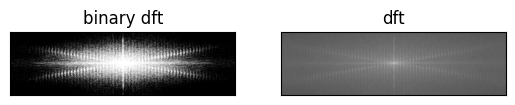

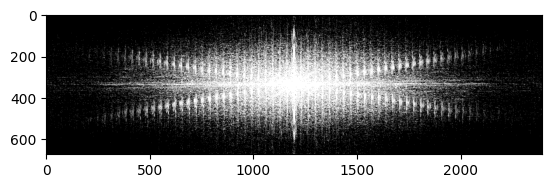

In [ ]:
# find the discrete fourier transform of the image
dft = cv2.dft(np.float32(test1),flags = cv2.DFT_COMPLEX_OUTPUT)

# shift zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(
      dft_shift[:,:,0],
      dft_shift[:,:,1])
   )

ret,thresh1 = cv2.threshold(magnitude_spectrum,190,255,cv2.THRESH_BINARY)

plt.subplot(121),plt.imshow(thresh1, cmap = 'gray')
plt.title('binary dft'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('dft'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(thresh1, cmap="gray")

In [ ]:
borderoutput = cv2.copyMakeBorder(
    test1, 0, 0, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
plt.imshow(borderoutput, cmap="gray")

NameError: ignored